In [1]:
import pandas as pd
import numpy as np
import investpy
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
from sklearn.linear_model import LogisticRegression
import talib as ta
from statsmodels.formula.api import logit


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [17, 5]

c:\users\ryan-pc\appdata\local\programs\python\python38-32\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
def getExponentialMovingAverage(close, days):
    ema = []
    ema.append(close[0])
    smooth = 2/(days+1) 
    for i in range(1,len(close)):
        ema.append(close[i] * smooth + ema[i-1] * (1-smooth))
    return ema

def expandMovingAverage(movingAverage, interval):
    index = 0
    ma_stock = pd.DataFrame(columns = ["MA" + str(interval)])
    for i in range(0,len(movingAverage)-1):
        ma_stock.loc[index] = movingAverage.iloc[i] ##adds the n element to the series, we also set the index rather than adding it
        diff = ((movingAverage.iloc[i+1] - movingAverage.iloc[i])/interval)
        mult = 1
        index += 1
        for a in range(index, index + interval - 1):
            ma_stock.loc[index] = (diff * mult) + movingAverage.iloc[i] #adds the difference between the n and n+1 to the series
            mult += 1
            index += 1
    return ma_stock

def ceildiv(a, b):
    return -(-a // b)

In [15]:
stocks = investpy.get_stocks_list()
def getInfo(stock, country, from_date, to_date, interval):
    stock = investpy.get_stock_historical_data(stock=stock, country=country, from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    sma_stock = stock['Close'].groupby(ceildiv(np.arange(len(stock['Close'])),interval)).mean()
    ema_stock = getExponentialMovingAverage(sma_stock, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(sma_stock, interval)
    stock.reset_index(inplace = True)
    
    ohlc = stock.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    ohlc['SMA'] = sma_stock
    ohlc['EMA'] = ema_stock

    chart.plot(ohlc['Date'], ohlc['SMA'], color='blue', label='SMA'+ str(interval))
    chart.plot(ohlc['Date'], ohlc['EMA'], color='purple', label='EMA'+ str(interval))
    
    for i in range(interval-1,len(ohlc['EMA']), interval): #interval - 1 because 0 should be counted
        if(i+interval < len(ema_stock)):
            if(ohlc['EMA'][i] > ohlc['EMA'][i+interval]):
                chart.plot(ohlc['Date'][i], ohlc['EMA'][i], 'o', color='red')
            else:
                chart.plot(ohlc['Date'][i], ohlc['EMA'][i], 'o', color='green')
                
    candlestick_ohlc(chart, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    chart.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    chart.legend(loc="lower right")
    plt.show()

##if stock info is not indexed
def searchAndGetInfo(stock, country, from_date, to_date, interval):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    stock = search_results[0].retrieve_historical_data(from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    sma_stock = stock['Close'].groupby(ceildiv(np.arange(len(stock['Close'])),interval)).mean()
    ema_stock = getExponentialMovingAverage(sma_stock, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(sma_stock, interval)
    stock.reset_index(inplace = True)

    ohlc = stock.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    ohlc['SMA'] = sma_stock
    ohlc['EMA'] = ema_stock

    chart.plot(ohlc['Date'], ohlc['SMA'], color='blue', label='SMA'+ str(interval))
    chart.plot(ohlc['Date'], ohlc['EMA'], color='purple', label='EMA'+ str(interval))
    
    for i in range(interval-1,len(ohlc['EMA']), interval): #interval - 1 because 0 should be counted
        if(i+interval < len(ema_stock)):
            if(ohlc['EMA'][i] > ohlc['EMA'][i+interval]):
                chart.plot(ohlc['Date'][i], ohlc['EMA'][i], 'o', color='red')
            else:
                chart.plot(ohlc['Date'][i], ohlc['EMA'][i], 'o', color='green')
                
    candlestick_ohlc(chart, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    chart.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    chart.legend(loc="lower right")
    plt.show()
    print(len(ohlc))
    
def retrieveInformation(stock, country):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    info = pd.Series(search_results[0].retrieve_information())
    print(info)
    
def getPercentageGrowth(stock, country, from_date, to_date):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    stock = search_results[0].retrieve_historical_data(from_date=from_date, to_date=to_date)
    growth = (stock['Close']/stock['Close'][0])*100
    
    fig, chart = plt.subplots()
    chart.plot(growth, label="growth")
    chart.legend(loc = "lower right")
    plt.show()

#test bed for in development functions
def testBed(stock, country, from_date, to_date, interval):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    stock = search_results[0].retrieve_historical_data(from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    sma_stock = stock['Close'].groupby(ceildiv(np.arange(len(stock['Close'])),interval)).mean()
    ema_stock = getExponentialMovingAverage(sma_stock, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(sma_stock, interval)
    stock.reset_index(inplace = True)
    
    ohlc = stock.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    #convert date to numerical data as training wont work for date type data.
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    ohlc['SMA'] = sma_stock
    ohlc['EMA'] = ema_stock
    ohlc['Corr'] = ohlc['Close'].rolling(window=interval).corr(ohlc['SMA']) ##could use EMA for more price change resilient MA
    ohlc['RSI'] = ta.RSI(np.array(ohlc['Close']), timeperiod = interval)
    
    # The "shift" here indicates that we are subtracting the "open" of the actual day to the "close" of the previous day
    ohlc['Open-Close'] = ohlc['Open'] - ohlc['Close'].shift(1)
    ohlc['Open-Open'] = ohlc['Open'] - ohlc['Open'].shift(1)
    print(ohlc)
    ohlc = ohlc.dropna() ##drops NaN values but also drops incomplete data
    print(ohlc)

    X = ohlc.iloc[:,1:11]
    
    # Here we take "-1" as parameter (inverse) to the shift function as we want 
    # the closing of the next day and not the previous day.
    # The numpy (np) function "where" creates a new variable called "y" where 
    # the value is "1" if the close of the next day is higher than the close of 
    # the actual day. In our case we create an array, but an additional column 
    # could have been created for example by replacing the "y" by "df['Target']" 
    # for example.
    y = np.where (ohlc['Close'].shift(-1) > ohlc['Close'],1,-1)
    
    #split the data into 70% validation and 30% test
    split = int(0.7*len(ohlc))
    
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    model = LogisticRegression()
    model = model.fit (X_train,y_train)
    
    coef = model.coef_
    
    newdf = X_train
    
    newdf = newdf.assign(up_down=pd.Series(y_train, index=newdf.index).values)

    newdf['up_down']= newdf['up_down'].replace(-1, 0)
    #We replace all the "-1" by "0", otherwise we'll get the following error message with this library since we need either a 0 or a 1 as dependent variables : "ValueError: endog must be in the unit interval".

    ##higher the P-Value of RSI, the higher the possibility that the data was generated by random chance
    #The lower the p-value, the more the feature has a predictive power
    model =logit("up_down ~ Open + High + Low + Close + SMA + Corr + RSI + Open-Close + Open-Open", data = newdf)
    results = model.fit()
    print(results.summary())
        
    #Make predictions using the testing set
    
#def testBed2(stock, country, from_date, to_date, interval):


        Date   Open   High    Low  Close      SMA       EMA      Corr  \
0    18305.0  1.872  1.872  1.809  1.854  1.85400  1.854000       NaN   
1    18306.0  1.818  1.899  1.809  1.890  1.86828  1.858760       NaN   
2    18309.0  1.872  1.952  1.872  1.925  1.88256  1.863520       NaN   
3    18310.0  1.934  1.943  1.899  1.908  1.89684  1.868280       NaN   
4    18311.0  1.925  1.925  1.881  1.916  1.91112  1.873040  0.799927   
..       ...    ...    ...    ...    ...      ...       ...       ...   
245  18677.0  7.890  8.120  7.750  7.800  7.75600  7.263337  0.164412   
246  18680.0  7.840  7.840  7.600  7.610  7.68780  7.273448  0.834134   
247  18681.0  7.600  7.610  7.340  7.450  7.61960  7.283559  0.912972   
248  18682.0  7.400  7.400  6.890  7.220  7.55140  7.293670  0.967225   
249  18684.0  7.000  7.380  7.000  7.380  7.48320  7.303781  0.876161   

           RSI  Open-Close  Open-Open  
0          NaN         NaN        NaN  
1          NaN      -0.036     -0.054  
2  

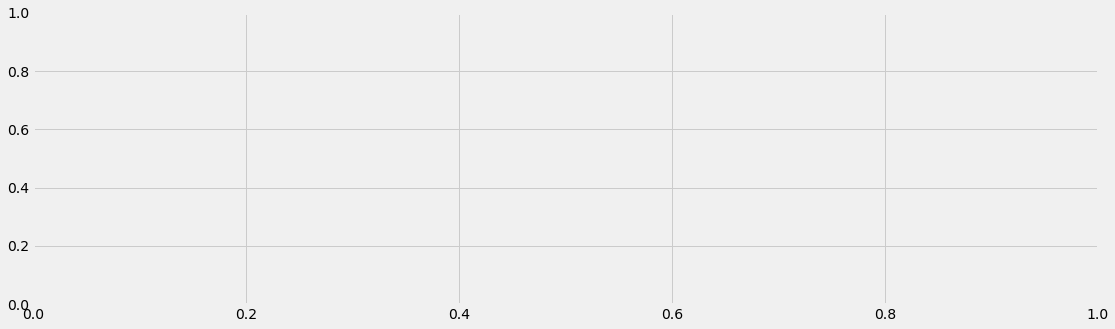

In [16]:
testBed('ACEN', 'Philippines', '13/2/2020', '27/2/2021', 5)

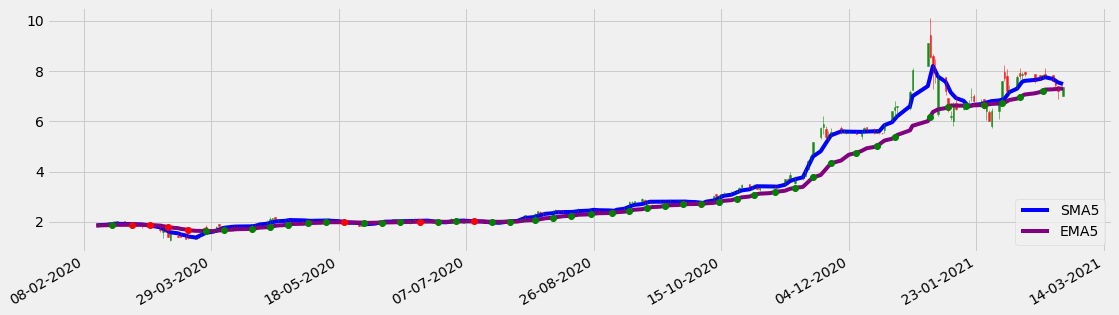

250


In [108]:
searchAndGetInfo('ACEN', 'Philippines', '13/2/2020', '1/3/2021', 5)

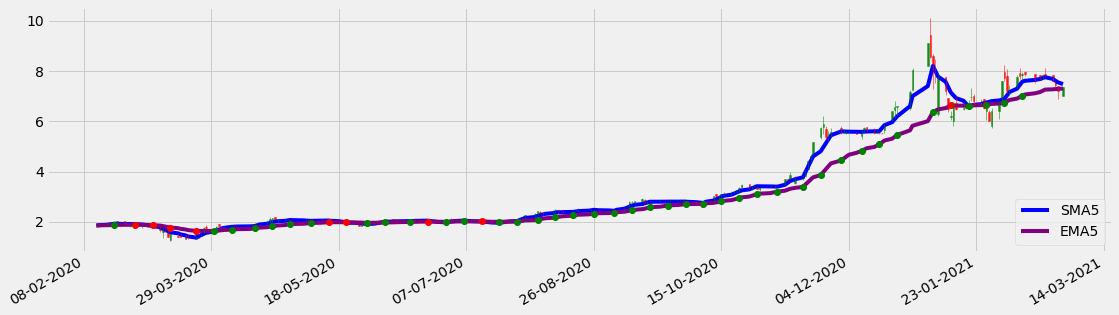

In [76]:
testBed2('ACEN', 'Philippines', '13/2/2020', '1/3/2021', 5)

In [9]:
retrieveInformation('ACEN', 'Philippines')

Prev. Close                   7.45
Todays Range            6.89 - 7.4
Revenue                19020000000
Open                           7.4
52 wk Range           1.39 - 11.28
EPS                           0.23
Volume                    75130800
Market Cap            115230000000
Dividend (Yield)        N/A (0.5%)
Average Vol. (3m)         58733281
P/E Ratio                    31.25
Beta                          1.15
1-Year Change              285.75%
Shares Outstanding     15960037644
dtype: object


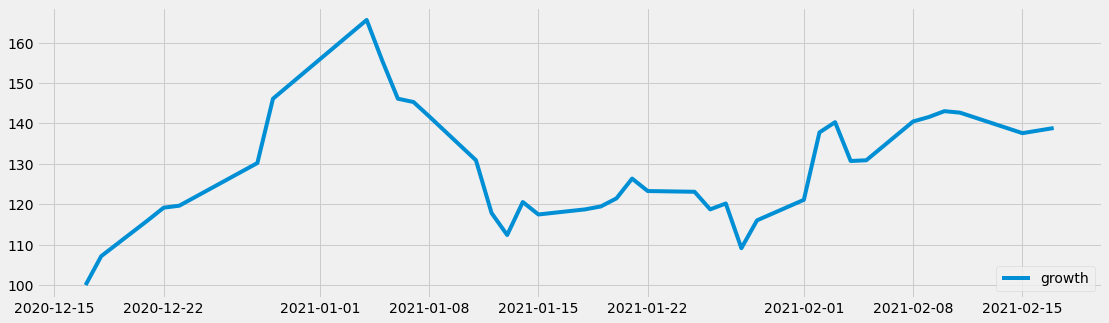

In [10]:
getPercentageGrowth('ACEN', 'Philippines', '17/12/2020', '17/2/2021')

In [ ]:
searchAndGetInfo('FRUIT', 'Philippines', '13/2/2020', '15/2/2021', 5)

In [11]:
##the chart will produce an incomplete moving average as there can be incomplete data, try to predict